In [29]:
# Step 1: Load dataset
import pandas as pd

df = pd.read_csv("EGA_SC.csv",  parse_dates=['OrderDate', 'ShipDate']) ##allow to read dates
df = df.sort_values('OrderDate').reset_index(drop=True)

In [30]:
# Compute Z-score for Sales and Profit

for col in ['Profit']:
    mean = df[col].mean()
    std = df[col].std()
    df[f'{col}_zscore'] = (df[col] - mean) / std

    #Step 2: Replace outliers with mean if |z| > 3
    df.loc[df[f'{col}_zscore'].abs() > 3, col] = mean



In [31]:
# Step 2: Feature and target definition

import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df['OrderDate_Ord'] = df['OrderDate'].map(lambda x: x.toordinal()) ##Converts datetime to numeric features
df['ShipDate_Ord'] = df['ShipDate'].map(lambda x: x.toordinal())

#Adding Temporal Features
df['OrderYear'] = df['OrderDate'].dt.year
df['OrderMonth'] = df['OrderDate'].dt.month
df['OrderDayOfWeek'] = df['OrderDate'].dt.dayofweek  # Monday=0, Sunday=6

df['ShipYear'] = df['ShipDate'].dt.year
df['ShipMonth'] = df['ShipDate'].dt.month
df['ShipDayOfWeek'] = df['ShipDate'].dt.dayofweek

df['ShipDelay'] = (df['ShipDate'] - df['OrderDate']).dt.days

#Feature Interaction
df['OrderDate_ShipDate'] = df['OrderDate'].astype(str) + "_" + df['ShipDate'].astype(str) ##Creates a new categorical feature that combines parameter, allows  model to learn interaction patterns
df['State_Month'] = df['State'] + "_" + df['OrderMonth'].astype(str)
df['OrderMonth_ShipMonth'] = df['OrderMonth'].astype(str) + "_" + df['ShipMonth'].astype(str)
df['ShipMode_OrderDayOfWeek'] = df['ShipMode'] + "_" + df['OrderDayOfWeek'].astype(str)
df['Discounts_State'] = df['Discounts'].astype(str) + "_" + df['State']
df['Discounts_ShipMonth'] = df['Discounts'].astype(str) + "_" + df['ShipMonth'].astype(str)
df['Discounts_ShipMode'] = df['Discounts'].astype(str) + "_" + df['ShipMode'].astype(str)
df['Discounts_OrderDayOfWeek'] = df['Discounts'].astype(str) + "_" + df['OrderDayOfWeek'].astype(str)


#Rolling Workflow by local trend
df['RollingSales30'] = df.groupby('State')['Sales'].shift(1).rolling(window=30, min_periods=1).mean()

# Global short-term context
df = df.sort_values('OrderDate')
df['Sales_lag_1'] = df['Sales'].shift(1)
df['Sales_rolling_7'] = df['Sales'].rolling(window=3, min_periods=1).mean()
df['Sales_rolling_std_7'] = df['Sales'].rolling(window=3, min_periods=1).std()

#Log or Box-Cox Transformations method
df['Sales'] = np.log1p(df['Sales'])  # log(1 + x) to handle zeros safely, applies a logarithmic transformation to reduce skewness in data

# Define X and Y
X_raw = df[['OrderDate_Ord', 'ShipDate_Ord', 'OrderYear',
            'OrderMonth', 'OrderDayOfWeek', 'ShipYear',
            'ShipMonth', 'ShipDayOfWeek', 'ShipDelay',
            'OrderDate_ShipDate', 'State_Month',
            'OrderDate_ShipDate','State_Month', 'OrderMonth_ShipMonth',
            'ShipMode_OrderDayOfWeek', 'Discounts_State', 'Discounts_ShipMonth',
            'Discounts_ShipMode', 'Discounts_OrderDayOfWeek','RollingSales30',
            'Sales_lag_1', 'Sales_rolling_7', 'Sales_rolling_std_7',
            'Sales', 'ShipMode', 'State', 'Category','Discounts',
             ]]
X = pd.get_dummies(X_raw)  # One-hot encode categorical variables

Y = df[['Sales', 'Profit']]
#Y = df[['Sales', 'Profit_scaled']]

# Force alignment
X.index = df.index
Y.index = df.index

#Z-score Normalization

# Ensure only columns present in X are selected for scaling
numerical_cols_to_scale = [col for col in X_raw.columns if col in X.columns]

# to Include log-transformed Sales
if 'Sales' in X.columns and 'Sales' not in numerical_cols_to_scale:
    numerical_cols_to_scale.append('Sales')

  # Filter to get only those columns present in X
numerical_cols = [col for col in X_raw if col in X.columns]

X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [32]:
# Step 3: Train/test split based on years
from sklearn.model_selection import train_test_split
train_mask = df['OrderDate'].dt.year <= 2021
test_mask = df['OrderDate'].dt.year >= 2022

X_train, X_test = X[train_mask], X[test_mask]
Y_train, Y_test = Y[train_mask], Y[test_mask]

In [33]:
df['Profit'] = df['Profit'].clip(lower=-2000, upper=2000)

In [34]:
# Step 4: Train a separate model for each target variable (Left)

from sklearn.ensemble import RandomForestRegressor #left side ML logic
import pandas as pd
models = {} ##initializes an empty dictionary named models, used for storing variable (Sales, Profit) — one model per [target]
Y_pred = pd.DataFrame(index=Y_test.index) ##creates an empty DataFrame for storing predictions (Y_pred), it uses same index as Y_test for comparison

for target in Y.columns: ##creates loop function, target works as a variable containing columns of Y for each iteration of loop
    model = RandomForestRegressor(n_estimators=50,  max_depth=10, random_state=42) ##n_estimator=100 create 100 decision tree, random_state=42 ensures reproducibility, max_depth limit tree size
    model.fit(X_train, Y_train[target]) ## Y_train[target] corresponding to (Sales, Profit)-training one model per target
    Y_pred[target] = model.predict(X_test) ##makes Y_pred[target] for each columns based on X_test
    models[target] = model ##stores the values of each columns one at a time into models

Y_pred_sales = np.expm1(Y_pred['Sales'])  ##inversing log1p




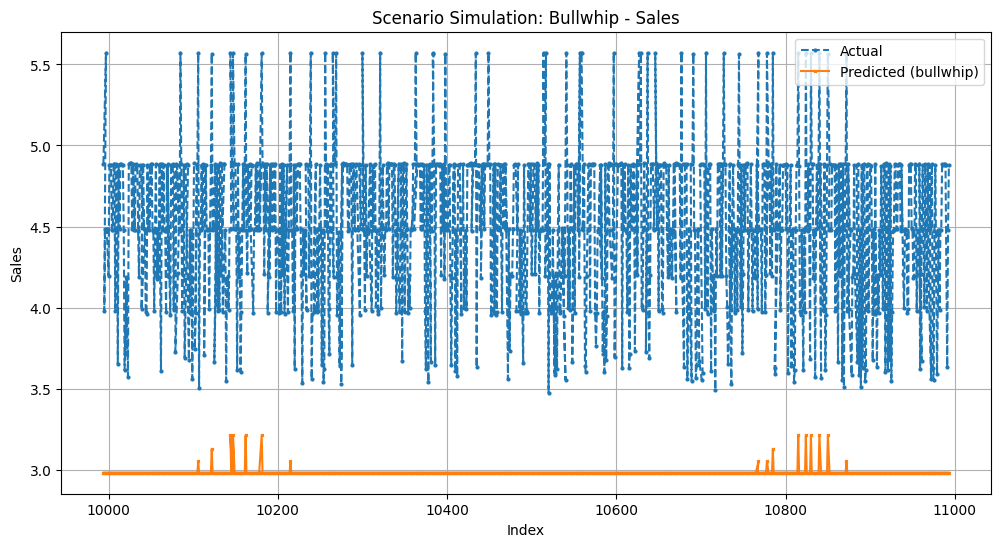

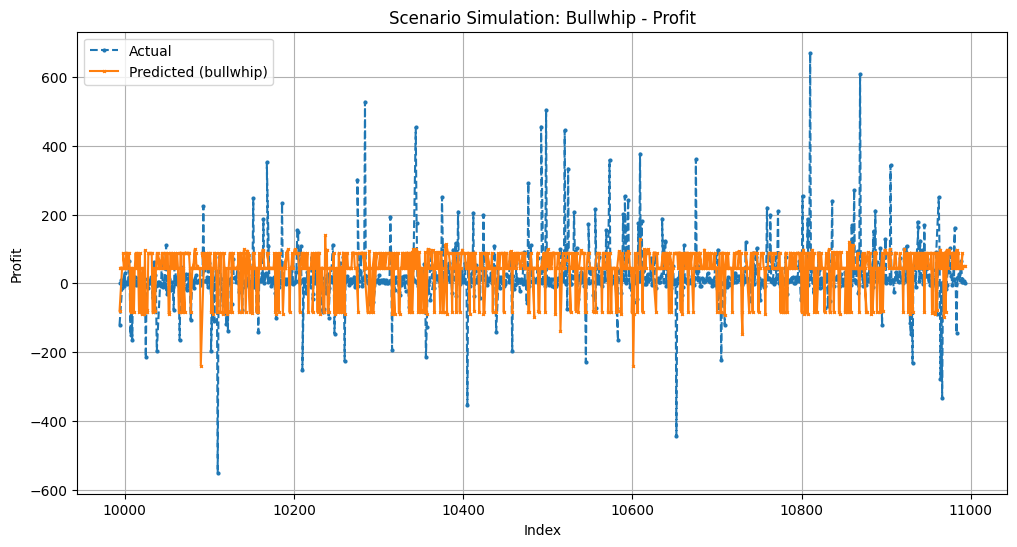

In [35]:
# === Step 4.1 SCENARIO-BASED SIMULATION LOGIC  ===

def generate_scenario_input(base_df, scenario='bullwhip', intensity=2.0):
    scenario_df = base_df.copy()

    if scenario == 'bullwhip':
        # Simulate demand spikes/noise
        trend = np.sin(np.linspace(0, 3 * np.pi, len(scenario_df))) * (intensity * 0.3)
        scenario_df['Sales'] = np.clip(scenario_df['Sales'] * (1 + trend), 0, None)

    elif scenario == 'market_clash':
        # Sharp drop in both sales and profit proxies
        scenario_df['Sales'] *= (1 - 0.3 * intensity)
        scenario_df['Sales_lag_1'] *= (1 - 0.3 * intensity)

    elif scenario == 'overstock':
        # Inflate lags, delay
        scenario_df['Sales_lag_1'] *= (1 + 0.2 * intensity)
        scenario_df['ShipDelay'] += int(2 * intensity)

    elif scenario == 'supply_chain_disruption':
        scenario_df['ShipDelay'] += int(5 * intensity)
        scenario_df['ShipDate_Ord'] += int(5 * intensity)

    # Re-scale numerical inputs
    # Make sure only numerical columns present in the current DataFrame are scaled
    current_numerical_cols = [col for col in numerical_cols if col in scenario_df.columns]
    scenario_df[current_numerical_cols] = scaler.transform(scenario_df[current_numerical_cols])

    # Match training feature set columns and order using reindex
    # This is crucial to ensure scenario_input has the same features as X_train
    scenario_df_final = scenario_df.reindex(columns=X_train.columns, fill_value=0)

    return scenario_df_final

# --- Example: Simulate Market Clash Scenario ---
scenario_name = 'bullwhip'
# Pass X_test directly to the function
scenario_input = generate_scenario_input(X_test, scenario=scenario_name, intensity=2.0)


Y_pred_scenario = pd.DataFrame(index=scenario_input.index)
for target in Y.columns:
    # Ensure the model for the current target is used
    Y_pred_scenario[target] = models[target].predict(scenario_input)

# --- Visualization: Actual vs Scenario Prediction ---
import matplotlib.pyplot as plt

for target in Y.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test.index, Y_test[target], label='Actual', linestyle='--', marker='o', markersize=2)
    plt.plot(Y_pred_scenario.index, Y_pred_scenario[target], label=f'Predicted ({scenario_name})', linestyle='-', marker='x', markersize=2)
    plt.title(f'Scenario Simulation: {scenario_name.capitalize()} - {target}')
    plt.xlabel('Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
# Step 5: Error analysis (Right Side)
from sklearn.metrics import mean_squared_error, r2_score

for target in Y.columns:
    mse = mean_squared_error(Y_test[target], Y_pred[target])
    print(f"{target} MSE: {mse:.2f}") ## again loop and :→ format specification; .2→2 digit after decimal; f→format as floating point number
    print(f"{target} - R2 Score:", r2_score(Y_test[target], Y_pred[target]))

Sales MSE: 0.00
Sales - R2 Score: 0.9991750309563302
Profit MSE: 6437.28
Profit - R2 Score: 0.05563181859461386


In [37]:
#6.1 Re-training:Residual-Based Synthetic Data Generation

import numpy as np

# Compute residuals (absolute errors)
residuals = (Y_test - Y_pred).abs() ##abs-gives out absolute value, only the size of error without sign(can be positive or negative)
residuals['avg_error'] = residuals.mean(axis=1) ##ranking the rows with highest prediction error and putting them into residuals

# Pick top N worst predictions (high avg error)
top_n = 25 ##defining count of how many top error value should be considered for refining the error(could be 10% of total dataset)
high_error_indices = residuals.sort_values(by='avg_error', ascending=False).head(top_n).index ##picking out top 100 highest error value

# Extract corresponding X rows as base for synthetic data
X_synthetic = X_test.loc[high_error_indices].copy() ## retrieving values of X_test which has worst prediction and putting it under X_synthetic
Y_synthetic = pd.DataFrame(index=X_synthetic.index)

for target in Y.columns:
    Y_synthetic[target] = models[target].predict(X_synthetic)



In [38]:
# 6.2 Re-training:Scenario simulation
scenario_name = 'bullwhip'
scenario_input = generate_scenario_input(X_test.copy(), scenario=scenario_name, intensity=2.0)
# Corrected line: use scenario_input instead of scenario_input_full
X_synthetic_scenario = scenario_input.sample(n=1000, random_state=42)


In [39]:
import numpy as np

# Create synthetic labels with volatility pattern
trend = np.sin(np.linspace(0, 3 * np.pi, len(X_synthetic_scenario))) * 0.3  # adjust multiplier as needed

Y_synthetic_scenario = pd.DataFrame(index=X_synthetic_scenario.index)

for target in Y.columns:
    if target == 'Sales':
        # Map trend to Sales
        base_value = Y_train['Sales'].mean()
        Y_synthetic_scenario[target] = base_value * (1 + trend)
    elif target == 'Profit':
        # Option 1: make profit roughly follow Sales with some scaling
        profit_trend = trend + np.random.normal(0, 0.05, len(trend))  # add small noise
        base_profit = Y_train['Profit'].mean()
        #Y_synthetic_scenario[target] = base_profit * (1 + profit_trend)
        profit_ratio = Y_train['Profit'] / (Y_train['Sales'] + 1e-6)  # avoid divide by zero
        avg_ratio = profit_ratio.mean()
        Y_synthetic_scenario['Profit'] = Y_synthetic_scenario['Sales'] * avg_ratio + np.random.normal(0, 50, len(Y_synthetic_scenario))



In [40]:
#6.3 Re-training model

X_combined = pd.concat([X_train, X_synthetic, X_synthetic_scenario], ignore_index=True)
Y_combined = pd.concat([Y_train, Y_synthetic, Y_synthetic_scenario], ignore_index=True)

for target in Y.columns:
    models[target].fit(X_combined, Y_combined[target])


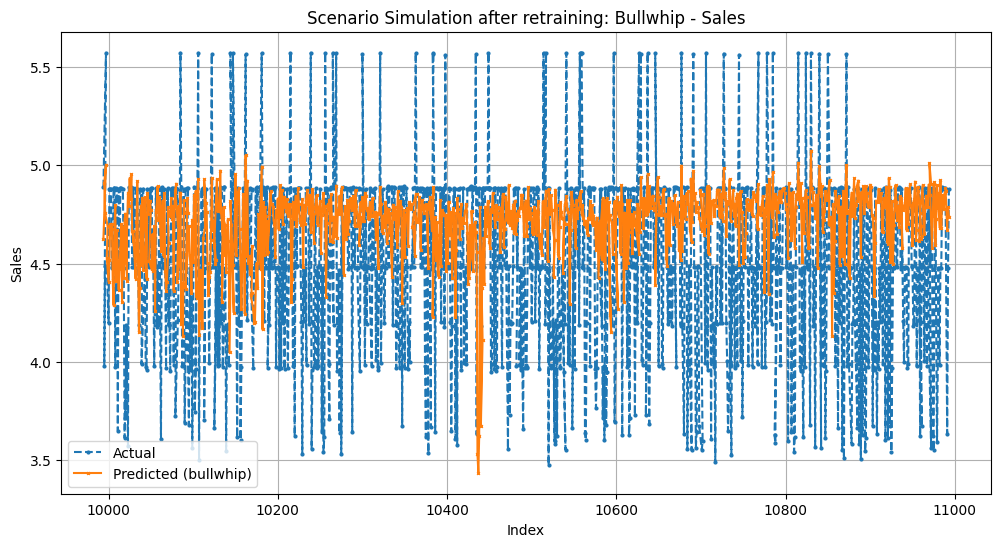

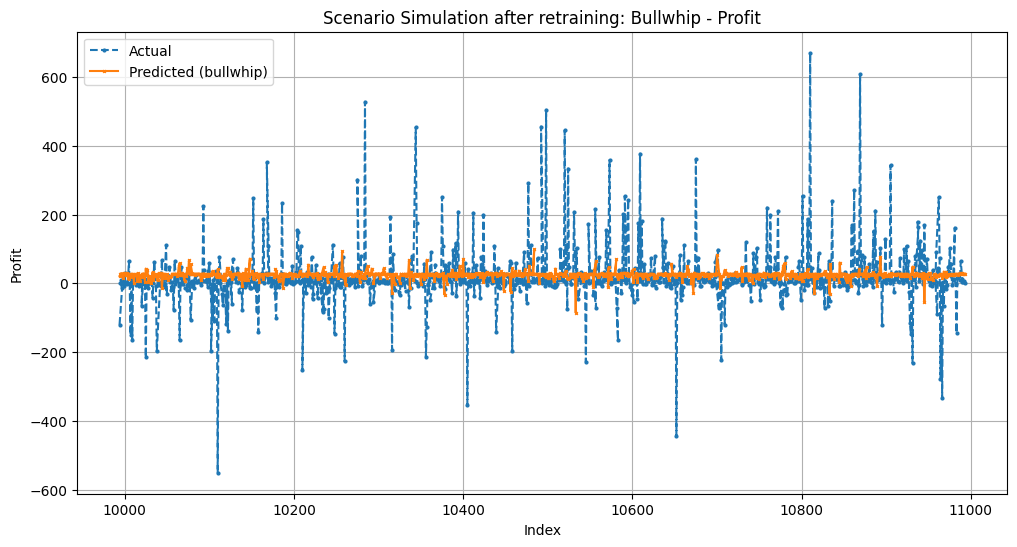

In [41]:
# --- Re-Simulate Market Clash Scenario ---
scenario_name = 'bullwhip'
# Pass X_test directly to the function
scenario_input = generate_scenario_input(X_test.copy(), scenario=scenario_name, intensity=2.0)

Y_pred_scenario_updated = pd.DataFrame(index=scenario_input.index)
for target in Y.columns:
    # Ensure the model for the current target is used
    Y_pred_scenario_updated[target] = models[target].predict(scenario_input)

# --- Visualization: Actual vs Scenario Prediction ---
import matplotlib.pyplot as plt

for target in Y.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test.index, Y_test[target], label='Actual', linestyle='--', marker='o', markersize=2)
    plt.plot(Y_pred_scenario_updated.index, Y_pred_scenario_updated[target], label=f'Predicted ({scenario_name})', linestyle='-', marker='x', markersize=2)
    plt.title(f'Scenario Simulation after retraining: {scenario_name.capitalize()} - {target}')
    plt.xlabel('Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
#8 error test on retained model
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Re-predict on the same test set using the updated model
Y_pred_updated = pd.DataFrame(index=Y_test.index)

for target in Y.columns:
    Y_pred_updated[target] = models[target].predict(X_test)

# Step 2: Recalculate error metrics
for target in Y.columns:
    mse = mean_squared_error(Y_test[target], Y_pred_updated[target])
    r2 = r2_score(Y_test[target], Y_pred_updated[target])
    print(f"{target} MSE: {mse:.2f}")
    print(f"{target} - R2 Score: {r2:.4f}")

Sales MSE: 0.00
Sales - R2 Score: 0.9993
Profit MSE: 6416.88
Profit - R2 Score: 0.0586


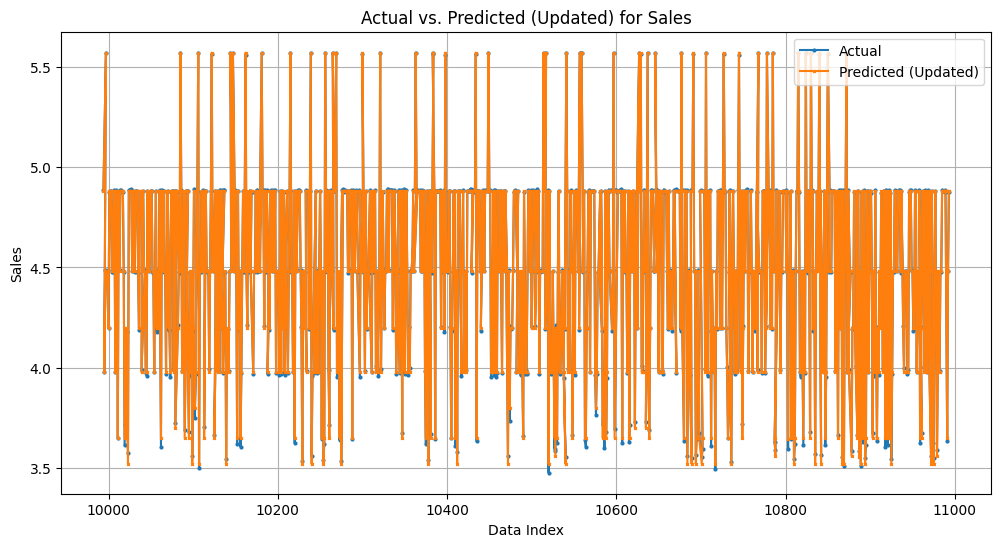

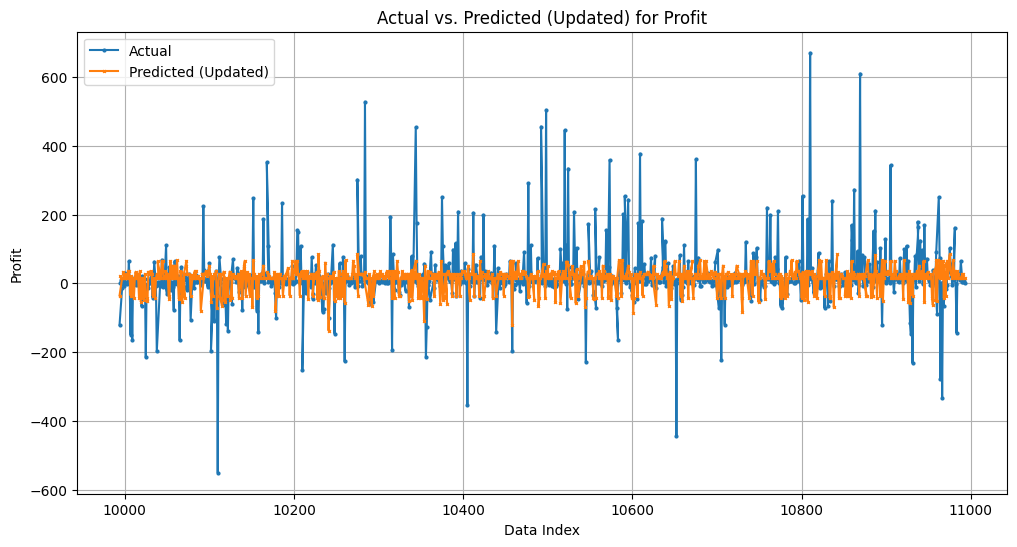

In [43]:
#9 line diagram comparing Y_test[target], Y_pred_updated[target] for each columns(targets)

import matplotlib.pyplot as plt

# Plotting the results for each target
for target in Y.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test.index, Y_test[target], label='Actual', marker='o', markersize=2)
    plt.plot(Y_pred_updated.index, Y_pred_updated[target], label='Predicted (Updated)', marker='x', markersize=2)
    plt.title(f'Actual vs. Predicted (Updated) for {target}')
    plt.xlabel('Data Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

<Axes: xlabel='Sales', ylabel='Sales'>

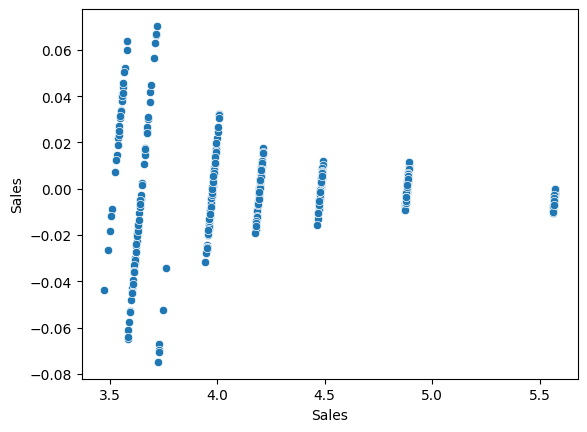

In [26]:
#Residual analysis for bias detection
import seaborn as sns
residuals = Y_test['Sales'] - Y_pred['Sales']
sns.scatterplot(x=Y_test['Sales'], y=residuals)